# 주암댐 망간 분석
* Mn_Quality_old1,2 사용

In [1]:
!pip install gdown

!gdown https://drive.google.com/uc?id=1AQoGdeBLZsgM0Kzvl4nAxRPfM0ebdSTZ --output Mn_Quality1_old.csv
!gdown https://drive.google.com/uc?id=1gJZjqtBzM-kTKOjyE2TbHpzk5Qa7-v19 --output Mn_Quality2_old.csv
!gdown https://drive.google.com/uc?id=1fGGVI9X9xuy98nEG86u2y5MRlBU2HU2W --output shared_data.zip    # 망간 데이터 다운로드

!gdown https://drive.google.com/uc?id=1JhYAbpVn7_DtW5PxHuOCvDUYncsY0cST --output NanumGothic.ttf    # 한글 그래프용 나눔 고딕 다운로드
!gdown https://drive.google.com/uc?id=1g3UeYk3SxlO8-Y9kzKCM3DNmajmg4eWR --output NanumGothic.otf
!gdown https://drive.google.com/uc?id=14XaW_5r2zGJ-h_ImK6e7ZE24Q7EBQup- --output water_function.py  # water_function.py 다운로드

Downloading...
From: https://drive.google.com/uc?id=1AQoGdeBLZsgM0Kzvl4nAxRPfM0ebdSTZ
To: /content/Mn_Quality1_old.csv
100% 10.0M/10.0M [00:00<00:00, 34.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1gJZjqtBzM-kTKOjyE2TbHpzk5Qa7-v19
To: /content/Mn_Quality2_old.csv
100% 51.8M/51.8M [00:00<00:00, 70.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGGVI9X9xuy98nEG86u2y5MRlBU2HU2W
To: /content/shared_data.zip
100% 7.58M/7.58M [00:00<00:00, 161MB/s]
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1JhYAbpVn7_DtW5PxHuOCvDUYncsY0cST 

Downloading...
From: https://drive.google.com/uc?id=1g3UeYk3SxlO8-Y9kzKCM3DNmajmg4eWR
To: /content/NanumGothic.otf
100% 2.27M/2.27M [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=14XaW_

In [2]:
# 데이터 폴더 생성
!mkdir data
!unzip ./shared_data.zip -d ./data

Archive:  ./shared_data.zip
  inflating: ./data/Mn_preci.csv     
  inflating: ./data/Mn_Mn.csv        
  inflating: ./data/Mn_weather.csv   
  inflating: ./data/Mn_Quality2.csv  
  inflating: ./data/Mn_Quality1.csv  


In [3]:
import os
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from matplotlib import rc
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import xgboost

from itertools import combinations
from tqdm import tqdm

import warnings
# from pandas.core.common import SettingWithCopyWarning
# warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import joblib
import pickle


from sklearn.impute import KNNImputer
from water_function import basic_chart, buildDataSet_DT
from water_function import total_chart, AL_GradientBoosting, AL_XGBoosting, AL_SVR, AL_GradientBoosting, AL_RandomForest, Performance_index

In [4]:
# matplotlib 한글화
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

fe = fm.FontEntry(
    fname=r'/content/NanumGothic.otf',
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 20, 'font.family': 'NanumGothic'}) # 폰트 설정

### 데이터 수집 및 가공

In [5]:
# 데이터 범위 지정
start_date = '2009-12-14'
end_date = '2019-12-31'

In [6]:
# raw_qu1 = pd.read_csv('./data/Mn_Quality1.csv', sep=',', encoding='CP949') # 댐축 2 (2015-11-18 ~ 2020-06-30)
# raw_qu2 = pd.read_csv('./data/Mn_Quality2.csv', sep=',', encoding='CP949') # 댐축 1 (2009-12-14 ~ 2015-11-19)

raw_qu1 = pd.read_csv('./Mn_Quality1_old.csv', sep=',', encoding='CP949') # 댐축 2 (2015-11-18 ~ 2020-06-30)
raw_qu2 = pd.read_csv('./Mn_Quality2_old.csv', sep=',', encoding='CP949') # 댐축 1 (2009-12-14 ~ 2015-11-19)

raw_mn = pd.read_csv('./data/Mn_Mn.csv', sep=',', encoding='CP949') # 망간
raw_pr = pd.read_csv('./data/Mn_preci.csv', sep=',', encoding='CP949') # 댐수위, 저수량, 강우량
raw_we = pd.read_csv('./data/Mn_weather.csv', sep=',', encoding='CP949') # 기온(평균, 최저, 최고), 풍속(최대, 평균)

raw_qu = pd.concat([raw_qu1, raw_qu2]) # raw_qu1과 raw_qu2는 기간만 다른 자료이므로 병합

In [7]:
# 중복데이터 확인
print("망간")
display(raw_mn[raw_mn.duplicated(keep=False)])
print("\n댐수위, 저수량")
display(raw_pr[raw_pr.duplicated(keep=False)])
print("\n기온 데이터")
display(raw_we[raw_we.duplicated(keep=False)])
print("\n댐 데이터")
display(raw_qu[raw_qu.duplicated(keep=False)])

망간


,Date,TMn_HS
1166,2018-07-16,0.123
1167,2018-07-16,0.123



댐수위, 저수량


,Date,댐수위,저수량,강우량



기온 데이터


,Date,평균기온,최저기온,최고기온,최대 풍속,평균 풍속



댐 데이터


,OBSCD,OBSNM,OBSDH,SRDWATITG,TBDT,RWL,PH,WTRTMP,ELCCND,DO,CHL,BGA
759,4007B7b,댐축2,2020-06-26,1,0.6,102.01,8.53,24.79,68.0,9.18,3.09,0.0
760,4007B7b,댐축2,2020-06-26,2,0.8,102.01,8.56,24.79,68.0,9.15,4.00,0.0
761,4007B7b,댐축2,2020-06-26,3,0.8,102.01,8.55,24.62,68.0,9.14,3.20,0.0
762,4007B7b,댐축2,2020-06-26,4,0.6,102.01,8.53,24.53,68.0,9.14,3.09,0.0
763,4007B7b,댐축2,2020-06-26,5,0.8,102.01,8.52,24.44,68.0,9.19,2.70,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
906428,4007B7a,댐축1,2009-12-14,11,2.0,99.13,7.10,10.70,67.0,8.40,2.00,NaN
906447,4007B7a,댐축1,2009-12-14,30,10.0,99.13,6.70,8.30,87.0,0.10,1.70,NaN
906458,4007B7a,댐축1,2009-12-14,7,2.0,99.13,7.10,10.70,67.0,8.40,1.70,NaN
906462,4007B7a,댐축1,2009-12-14,11,2.0,99.13,7.10,10.70,67.0,8.40,2.00,NaN


In [8]:
# 중복데이터 제거
raw_mn = raw_mn[-raw_mn.duplicated()]
# raw_qu = raw_qu[-raw_qu.duplicated()]

In [9]:
raw_mn.set_index(raw_mn.columns[0], drop=True, inplace=True)
raw_mn.index.name = "date"
raw_mn.index = pd.to_datetime(raw_mn.index)
display(raw_mn)

,TMn_HS
date,
1996-04-04,0.000
1996-04-12,0.000
1996-04-18,0.000
1996-04-25,0.000
1996-05-02,0.000
...,...
2020-01-13,0.030
2020-01-20,0.046
2020-01-28,0.014


In [10]:
print(raw_mn.mean())

TMn_HS    0.055956
dtype: float64


In [11]:
raw_pr.set_index(raw_pr.columns[0], drop=True, inplace=True)
raw_pr.index.name = "date"
raw_pr.index = pd.to_datetime(raw_pr.index)
display(raw_pr)

,댐수위,저수량,강우량
date,,,
1996-04-01,94.94,155.391,0.000
1996-04-02,94.92,155.127,0.000
1996-04-03,94.90,154.864,0.000
1996-04-04,94.87,154.469,0.000
1996-04-05,94.85,154.206,0.000
...,...,...,...
2019-12-27,105.30,334.998,0.460
2019-12-28,105.27,334.294,0.000
2019-12-29,105.24,333.592,10.271


In [12]:
raw_we.set_index(raw_we.columns[0], drop=True, inplace=True)
raw_we.index.name = "date"
raw_we.index = pd.to_datetime(raw_we.index)
display(raw_we)

,평균기온,최저기온,최고기온,최대 풍속,평균 풍속
date,,,,,
1996-04-01,4.6,1.2,10.8,6.2,4.1
1996-04-02,3.7,-0.7,8.8,7.0,4.4
1996-04-03,4.0,-1.6,10.6,7.8,3.9
1996-04-04,4.2,-3.9,13.3,6.8,3.0
1996-04-05,6.1,-5.0,17.7,5.1,2.5
...,...,...,...,...,...
2019-12-27,0.8,-4.2,5.2,6.2,3.4
2019-12-28,-0.3,-6.0,8.2,3.2,1.0
2019-12-29,1.7,-5.4,6.2,2.0,0.5


In [13]:
# old용
# raw_qu 의 각 변수는 하루에 2~5회 측정하는 경우가 있어 날짜&수심별로 평균
data_qu = raw_qu[raw_qu.columns[2:]].groupby(['OBSDH', 'SRDWATITG']).mean().reset_index(level=1)
data_qu.index = pd.DatetimeIndex(data_qu.index)
data_qu.index.name = 'date'
display(data_qu)

,SRDWATITG,TBDT,RWL,PH,WTRTMP,ELCCND,DO,CHL,BGA
date,,,,,,,,,
2009-12-14,1,2.00,99.130,7.100,10.700,67.0,8.550,1.950,NaN
2009-12-14,2,2.00,99.130,7.100,10.700,67.0,8.500,1.750,NaN
2009-12-14,3,2.00,99.130,7.100,10.700,67.0,8.500,2.250,NaN
2009-12-14,4,2.00,99.130,7.100,10.700,67.0,8.500,2.100,NaN
2009-12-14,5,2.00,99.130,7.100,10.700,67.0,8.450,1.600,NaN
...,...,...,...,...,...,...,...,...,...
2020-06-30,29,1.08,102.204,7.478,11.490,63.8,7.716,0.698,423.6
2020-06-30,30,1.32,102.204,7.478,11.376,63.8,7.664,0.780,423.6
2020-06-30,31,1.48,102.204,7.474,11.308,64.0,7.522,0.600,423.6


$$ PEA = \frac{1}{h} \int_{-h}^0 (\bar{\rho} - \rho)gzdz $$  
$$ \bar{\rho} = \frac{1}{h} \int_{-h}^0 \rho dz$$  
$ h $ : 총 수심  
$ \bar{\rho} $ : 평균밀도  
$ \rho $ : 밀도  
$ g $ : 중력가속도

In [14]:
# old 현재
# 각 날짜별 MAX 수심 h 계산
data_qu = pd.concat([data_qu, data_qu.groupby('date').max()['SRDWATITG']], axis=1)
data_qu.columns = list(data_qu.columns[:-1]) + ['DEPTH_MAX']

In [15]:
# Z(팔길이) 계산
COUNT = 0 # list_z 인덱스 지정용
DAY_COUNT = 0 # 날짜 넘어가는 거 체크용 (처음 열에서는 0으로)
depth_before = 0

list_z = [np.nan] * len(data_qu)
for date in sorted(set(data_qu.index)):
    data_day = data_qu.loc[date]

    # 수심자료가 1개일 경우에는 pd.Series로 넘어옴...
    if type(data_day) == pd.Series:
        list_z[COUNT] = np.nan
        COUNT += 1
        continue

    # 수심자료가 2개 이상이어서 pd.DataFrmae 으로 넘어옴
    else:

        # 수심자료가 20개 미만
        if len(data_day) <= 25:
            for _ in data_day['SRDWATITG']:
                list_z[COUNT] = np.nan
                COUNT += 1

        # (정상) 수심자료가 20개 이상
        else:
            for idx, row in data_day.iterrows():
                # 간단하게 (최대수심-관측수심) 으로 수행
                # 향후 필요 시 조금 더 디테일하게 계산
                list_z[COUNT] = row['DEPTH_MAX'] - row['SRDWATITG']
                COUNT += 1

data_qu['z'] = list_z

In [16]:
# 수심별 밀도 계산 함수
C1 = 0.000055
C2 = 0.008436
C3 = 0.064579
C4 = 999.842381
def calculate_density(depth):
    return C1 * (depth ** 3) - C2 * (depth ** 2) + C3 * depth + C4

In [17]:
data_qu['density'] = data_qu['WTRTMP'].apply(calculate_density)

In [18]:
GRAVITY_ACC = 9.81

# PEA 계산
data_pea = pd.DataFrame(None, columns=['pea'], index=pd.date_range(start='2009-12-14', end='2020-06-30'))

for date in sorted(set(data_qu.index)):
    data_day = data_qu.loc[date]

    # 수심별 밀도가 계산되었을 경우 (수심이 21개 이상인 경우)
    if not np.isnan(data_day['z']).any():
        pea = 0
        mean_density = data_day['density'].mean()
        for depth, density in zip(data_day['z'], data_day['density']):
            pea += (mean_density - density) * GRAVITY_ACC * depth

        data_pea.loc[date]['pea'] = pea

In [19]:
data_pea

,pea
2009-12-14,213.807633
2009-12-15,183.635173
2009-12-16,147.086489
2009-12-17,97.320201
2009-12-18,71.56002
...,...
2020-06-26,2347.82777
2020-06-27,2460.525738
2020-06-28,2461.394339
2020-06-29,2516.587256


In [20]:
# 수질 데이터 평균
data = data_qu.groupby('date').mean()[['ELCCND', 'DO' ,'PH', 'WTRTMP']]
data.index = pd.to_datetime(data.index)
data.index.name = 'date'
display(data)

,ELCCND,DO,PH,WTRTMP
date,,,,
2009-12-14,73.352941,6.089706,6.983824,10.047059
2009-12-15,74.377451,5.771078,6.971814,9.800000
2009-12-16,75.636223,5.801548,6.972601,9.465170
2009-12-17,73.506920,6.497405,6.992561,9.449827
2009-12-18,72.655462,6.900000,7.010924,9.335714
...,...,...,...,...
2020-06-26,65.580303,8.308167,7.794803,15.602121
2020-06-27,65.630303,8.449091,7.762000,15.803212
2020-06-28,66.090909,8.315152,7.768970,15.835697


In [21]:
data = pd.concat([data, raw_pr], axis=1).loc[start_date:end_date]
# display(data)
# data = pd.concat([data, raw_we], axis=1).loc[start_date:end_date]
# display(data)
data = pd.concat([data, raw_mn], axis=1).loc[start_date:end_date]
# display(data)
data = pd.concat([data, data_pea], axis=1).loc[start_date:end_date]
display(data)

,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS,pea
2009-12-14,73.352941,6.089706,6.983824,10.047059,99.11,217.506,0.000,NaN,213.807633
2009-12-15,74.377451,5.771078,6.971814,9.800000,99.08,217.003,0.000,NaN,183.635173
2009-12-16,75.636223,5.801548,6.972601,9.465170,99.04,216.334,0.000,0.162,147.086489
2009-12-17,73.506920,6.497405,6.992561,9.449827,99.01,215.834,0.000,NaN,97.320201
2009-12-18,72.655462,6.900000,7.010924,9.335714,98.98,215.334,0.100,NaN,71.56002
...,...,...,...,...,...,...,...,...,...
2019-12-27,64.261111,8.770889,6.912889,10.409722,105.30,334.998,0.460,NaN,18.426528
2019-12-28,64.083333,8.814833,6.919778,10.305833,105.27,334.294,0.000,NaN,4.099896
2019-12-29,63.986111,8.862361,6.925972,10.217986,105.24,333.592,10.271,NaN,3.426441
2019-12-30,63.933333,8.925000,6.932889,10.137333,105.20,332.657,0.332,0.044,3.047934


In [22]:
data.describe()

,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS
count,3355.000000,3355.000000,3355.000000,3355.000000,3670.000000,3670.000000,3670.000000,524.000000
mean,77.977154,8.765014,7.024341,12.020311,99.895071,234.469074,3.942402,0.072761
std,18.344189,6.182721,0.874708,5.639218,4.250223,75.628779,13.944065,0.070944
min,0.000000,0.000000,0.000000,0.000000,90.020000,94.791000,0.000000,0.008000
25%,67.697756,5.802370,6.710079,7.030524,96.820000,176.171000,0.000000,0.026000
50%,75.000000,8.066490,7.047917,12.240640,99.830000,224.173000,0.000000,0.049000
75%,85.040000,11.124408,7.476587,16.809198,103.020000,284.872000,0.700000,0.091000
max,162.190476,73.677150,10.829141,99.677419,109.270000,440.545000,206.676000,0.537000


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3670 entries, 2009-12-14 to 2019-12-31
Freq: D
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ELCCND  3355 non-null   float64
 1   DO      3355 non-null   float64
 2   PH      3355 non-null   float64
 3   WTRTMP  3355 non-null   float64
 4   댐수위     3670 non-null   float64
 5   저수량     3670 non-null   float64
 6   강우량     3670 non-null   float64
 7   TMn_HS  524 non-null    float64
 8   pea     2425 non-null   object 
dtypes: float64(8), object(1)
memory usage: 286.7+ KB


In [24]:
data.describe()

,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS
count,3355.000000,3355.000000,3355.000000,3355.000000,3670.000000,3670.000000,3670.000000,524.000000
mean,77.977154,8.765014,7.024341,12.020311,99.895071,234.469074,3.942402,0.072761
std,18.344189,6.182721,0.874708,5.639218,4.250223,75.628779,13.944065,0.070944
min,0.000000,0.000000,0.000000,0.000000,90.020000,94.791000,0.000000,0.008000
25%,67.697756,5.802370,6.710079,7.030524,96.820000,176.171000,0.000000,0.026000
50%,75.000000,8.066490,7.047917,12.240640,99.830000,224.173000,0.000000,0.049000
75%,85.040000,11.124408,7.476587,16.809198,103.020000,284.872000,0.700000,0.091000
max,162.190476,73.677150,10.829141,99.677419,109.270000,440.545000,206.676000,0.537000


### 망간 머신러닝 예측

In [25]:
train_data = data

In [26]:
# # KNN Imputer
# knn_imputer = KNNImputer(n_neighbors=6)

# train_columns = train_data.drop(['mn'], axis=1).columns
# train_data[train_columns] = knn_imputer.fit_transform(train_data[train_columns])
# display(train_data)
# print(train_data.info())
# mn 선형보간
train_data['mn_linear'] = train_data['TMn_HS'].interpolate(method='linear')
train_data['mn_reg1'] = train_data['mn_linear'].shift(1)
train_data['mn_reg2'] = train_data['mn_linear'].shift(2)
train_data['mn_reg3'] = train_data['mn_linear'].shift(3)
train_data['mn_reg4'] = train_data['mn_linear'].shift(4)
train_data['mn_reg5'] = train_data['mn_linear'].shift(5)
train_data

,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS,pea,mn_linear,mn_reg1,mn_reg2,mn_reg3,mn_reg4,mn_reg5
2009-12-14,73.352941,6.089706,6.983824,10.047059,99.11,217.506,0.000,NaN,213.807633,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-15,74.377451,5.771078,6.971814,9.800000,99.08,217.003,0.000,NaN,183.635173,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-16,75.636223,5.801548,6.972601,9.465170,99.04,216.334,0.000,0.162,147.086489,0.162,NaN,NaN,NaN,NaN,NaN
2009-12-17,73.506920,6.497405,6.992561,9.449827,99.01,215.834,0.000,NaN,97.320201,0.164,0.162,NaN,NaN,NaN,NaN
2009-12-18,72.655462,6.900000,7.010924,9.335714,98.98,215.334,0.100,NaN,71.56002,0.166,0.164,0.162,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,64.261111,8.770889,6.912889,10.409722,105.30,334.998,0.460,NaN,18.426528,0.047,0.048,0.049,0.050,0.051,0.049571
2019-12-28,64.083333,8.814833,6.919778,10.305833,105.27,334.294,0.000,NaN,4.099896,0.046,0.047,0.048,0.049,0.050,0.051000
2019-12-29,63.986111,8.862361,6.925972,10.217986,105.24,333.592,10.271,NaN,3.426441,0.045,0.046,0.047,0.048,0.049,0.050000
2019-12-30,63.933333,8.925000,6.932889,10.137333,105.20,332.657,0.332,0.044,3.047934,0.044,0.045,0.046,0.047,0.048,0.049000


In [27]:
# 정규화
display(train_data)
scaler = MinMaxScaler()
scaler.fit(train_data[train_data.columns])
train_data_ = scaler.transform(train_data[train_data.columns])
train_data = pd.DataFrame(train_data_, columns=train_data.columns, index=train_data.index)
train_data

,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS,pea,mn_linear,mn_reg1,mn_reg2,mn_reg3,mn_reg4,mn_reg5
2009-12-14,73.352941,6.089706,6.983824,10.047059,99.11,217.506,0.000,NaN,213.807633,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-15,74.377451,5.771078,6.971814,9.800000,99.08,217.003,0.000,NaN,183.635173,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-16,75.636223,5.801548,6.972601,9.465170,99.04,216.334,0.000,0.162,147.086489,0.162,NaN,NaN,NaN,NaN,NaN
2009-12-17,73.506920,6.497405,6.992561,9.449827,99.01,215.834,0.000,NaN,97.320201,0.164,0.162,NaN,NaN,NaN,NaN
2009-12-18,72.655462,6.900000,7.010924,9.335714,98.98,215.334,0.100,NaN,71.56002,0.166,0.164,0.162,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,64.261111,8.770889,6.912889,10.409722,105.30,334.998,0.460,NaN,18.426528,0.047,0.048,0.049,0.050,0.051,0.049571
2019-12-28,64.083333,8.814833,6.919778,10.305833,105.27,334.294,0.000,NaN,4.099896,0.046,0.047,0.048,0.049,0.050,0.051000
2019-12-29,63.986111,8.862361,6.925972,10.217986,105.24,333.592,10.271,NaN,3.426441,0.045,0.046,0.047,0.048,0.049,0.050000
2019-12-30,63.933333,8.925000,6.932889,10.137333,105.20,332.657,0.332,0.044,3.047934,0.044,0.045,0.046,0.047,0.048,0.049000


,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS,pea,mn_linear,mn_reg1,mn_reg2,mn_reg3,mn_reg4,mn_reg5
2009-12-14,0.452264,0.082654,0.644910,0.100796,0.472208,0.354920,0.000000,NaN,0.037601,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-15,0.458581,0.078329,0.643801,0.098317,0.470649,0.353465,0.000000,NaN,0.032547,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-16,0.466342,0.078743,0.643874,0.094958,0.468571,0.351530,0.000000,0.291115,0.026426,0.291115,NaN,NaN,NaN,NaN,NaN
2009-12-17,0.453214,0.088188,0.645717,0.094804,0.467013,0.350084,0.000000,NaN,0.018091,0.294896,0.291115,NaN,NaN,NaN,NaN
2009-12-18,0.447964,0.093652,0.647413,0.093659,0.465455,0.348638,0.000484,NaN,0.013776,0.298677,0.294896,0.291115,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.396208,0.119045,0.638360,0.104434,0.793766,0.694734,0.002226,NaN,0.004877,0.073724,0.075614,0.077505,0.079395,0.081285,0.078585
2019-12-28,0.395112,0.119641,0.638996,0.103392,0.792208,0.692698,0.000000,NaN,0.002477,0.071834,0.073724,0.075614,0.077505,0.079395,0.081285
2019-12-29,0.394512,0.120286,0.639568,0.102511,0.790649,0.690667,0.049696,NaN,0.002365,0.069943,0.071834,0.073724,0.075614,0.077505,0.079395
2019-12-30,0.394187,0.121137,0.640207,0.101701,0.788571,0.687963,0.001606,0.068053,0.002301,0.068053,0.069943,0.071834,0.073724,0.075614,0.077505


In [28]:
# 종속 변수를 다시 집어 넣기
train_data['mn'] = data['TMn_HS']
train_data

# leadtime 적용
train_data['mn_linear'] = train_data['mn'].interpolate(method='linear')
train_data['mn1real'] = train_data['mn_linear'].shift(-1)
train_data['mn2real'] = train_data['mn_linear'].shift(-2)
train_data['mn3real'] = train_data['mn_linear'].shift(-3)
train_data['mn4real'] = train_data['mn_linear'].shift(-4)
# train_data['mn5real'] = train_data['mn_linear'].shift(-5)
display(train_data)

# 종속변수의 min max 설정
mn_max = train_data['mn'].max()
mn_min = train_data['mn'].min()

print(mn_max)
print(mn_min)


,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS,pea,mn_linear,mn_reg1,mn_reg2,mn_reg3,mn_reg4,mn_reg5,mn,mn1real,mn2real,mn3real,mn4real
2009-12-14,0.452264,0.082654,0.644910,0.100796,0.472208,0.354920,0.000000,NaN,0.037601,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162,0.164,0.166
2009-12-15,0.458581,0.078329,0.643801,0.098317,0.470649,0.353465,0.000000,NaN,0.032547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.162,0.164,0.166,0.168
2009-12-16,0.466342,0.078743,0.643874,0.094958,0.468571,0.351530,0.000000,0.291115,0.026426,0.162,NaN,NaN,NaN,NaN,NaN,0.162,0.164,0.166,0.168,0.170
2009-12-17,0.453214,0.088188,0.645717,0.094804,0.467013,0.350084,0.000000,NaN,0.018091,0.164,0.291115,NaN,NaN,NaN,NaN,NaN,0.166,0.168,0.170,0.172
2009-12-18,0.447964,0.093652,0.647413,0.093659,0.465455,0.348638,0.000484,NaN,0.013776,0.166,0.294896,0.291115,NaN,NaN,NaN,NaN,0.168,0.170,0.172,0.174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.396208,0.119045,0.638360,0.104434,0.793766,0.694734,0.002226,NaN,0.004877,0.047,0.075614,0.077505,0.079395,0.081285,0.078585,NaN,0.046,0.045,0.044,0.044
2019-12-28,0.395112,0.119641,0.638996,0.103392,0.792208,0.692698,0.000000,NaN,0.002477,0.046,0.073724,0.075614,0.077505,0.079395,0.081285,NaN,0.045,0.044,0.044,NaN
2019-12-29,0.394512,0.120286,0.639568,0.102511,0.790649,0.690667,0.049696,NaN,0.002365,0.045,0.071834,0.073724,0.075614,0.077505,0.079395,NaN,0.044,0.044,NaN,NaN
2019-12-30,0.394187,0.121137,0.640207,0.101701,0.788571,0.687963,0.001606,0.068053,0.002301,0.044,0.069943,0.071834,0.073724,0.075614,0.077505,0.044,0.044,NaN,NaN,NaN


0.537
0.008


In [29]:
train_data.describe()

,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS,pea,mn_linear,mn_reg1,mn_reg2,mn_reg3,mn_reg4,mn_reg5,mn,mn1real,mn2real,mn3real,mn4real
count,3355.000000,3355.000000,3355.000000,3355.000000,3670.000000,3670.000000,3670.000000,524.000000,2425.000000,3668.000000,3667.000000,3666.000000,3665.000000,3664.000000,3663.000000,524.000000,3668.000000,3668.000000,3667.000000,3666.000000
mean,0.480775,0.118965,0.648652,0.120592,0.512991,0.403981,0.019075,0.122422,0.260738,0.072864,0.122632,0.122646,0.122661,0.122675,0.122688,0.072761,0.072864,0.072864,0.072840,0.072815
std,0.113103,0.083916,0.080773,0.056575,0.220791,0.218736,0.067468,0.134110,0.242380,0.067976,0.128513,0.128528,0.128542,0.128557,0.128572,0.070944,0.067976,0.067976,0.067969,0.067962
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008000,0.008000,0.008000,0.008000,0.008000
25%,0.417397,0.078754,0.619632,0.070533,0.353247,0.235370,0.000000,0.034026,0.020045,0.027554,0.036930,0.036896,0.036862,0.036862,0.036862,0.026000,0.027554,0.027554,0.027536,0.027518
50%,0.462419,0.109484,0.650829,0.122803,0.509610,0.374202,0.000000,0.077505,0.215987,0.051650,0.082609,0.082622,0.082636,0.082636,0.082636,0.049000,0.051650,0.051650,0.051600,0.051586
75%,0.524322,0.150989,0.690414,0.168636,0.675325,0.549758,0.003387,0.156900,0.434670,0.090031,0.155128,0.155187,0.155246,0.155305,0.155364,0.091000,0.090031,0.090031,0.090000,0.090000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.537000,1.000000,1.000000,1.000000,1.000000,1.000000,0.537000,0.537000,0.537000,0.537000,0.537000


In [30]:
train_data.dropna(subset=['mn1real','mn4real','mn_reg5','DO'], inplace=True) # null값 삭제
train_data

,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS,pea,mn_linear,mn_reg1,mn_reg2,mn_reg3,mn_reg4,mn_reg5,mn,mn1real,mn2real,mn3real,mn4real
2009-12-21,0.443560,0.104519,0.651474,0.088770,0.460260,0.343840,0.001452,NaN,0.009092,0.172000,0.306238,0.302457,0.298677,0.294896,0.291115,NaN,0.174000,0.193000,0.212000,0.231000
2009-12-24,0.000018,0.108223,0.645318,0.086160,0.455065,0.339065,0.000000,NaN,0.003851,0.212000,0.349716,0.313800,0.310019,0.306238,0.302457,NaN,0.231000,0.250000,0.269000,0.288000
2009-12-29,0.000000,0.108674,0.646730,0.079118,0.446234,0.331016,0.000000,0.565217,0.002601,0.307000,0.529301,0.493384,0.457467,0.421550,0.385633,0.307,0.303333,0.299667,0.296000,0.292333
2009-12-30,0.000000,0.113472,0.646404,0.078261,0.444156,0.329133,0.000000,NaN,0.003001,0.303333,0.565217,0.529301,0.493384,0.457467,0.421550,NaN,0.299667,0.296000,0.292333,0.288667
2009-12-31,0.000000,0.118853,0.646532,0.076654,0.442597,0.327721,0.003387,NaN,0.002359,0.299667,0.558286,0.565217,0.529301,0.493384,0.457467,NaN,0.296000,0.292333,0.288667,0.285000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.392029,0.118225,0.638743,0.108422,0.801039,0.704278,0.000000,0.081285,0.006204,0.051000,0.078585,0.075884,0.073184,0.070483,0.067783,0.051,0.050000,0.049000,0.048000,0.047000
2019-12-24,0.392200,0.118531,0.638575,0.107742,0.799481,0.702225,0.000000,NaN,0.005604,0.050000,0.081285,0.078585,0.075884,0.073184,0.070483,NaN,0.049000,0.048000,0.047000,0.046000
2019-12-25,0.392645,0.118218,0.638032,0.106714,0.797403,0.699494,0.000000,NaN,0.004834,0.049000,0.079395,0.081285,0.078585,0.075884,0.073184,NaN,0.048000,0.047000,0.046000,0.045000
2019-12-26,0.392508,0.118935,0.638155,0.105815,0.795325,0.696773,0.004809,NaN,0.004221,0.048000,0.077505,0.079395,0.081285,0.078585,0.075884,NaN,0.047000,0.046000,0.045000,0.044000


In [ ]:
# def buildDataSet_MN(timeSeries, y, target=0, seqLength=1, pre=0, shuffle=False):
#     xdata = pd.DataFrame()
#     ydata = pd.DataFrame()

#     count = 0
#     for i in range(seqLength, len(timeSeries)):
#         if np.isnan(timeSeries.iloc[i][y]):
#             continue
#         tmp = pd.DataFrame()
#         for j in range(seqLength+1):
#             tmp = pd.concat([tmp, timeSeries.iloc[i-(seqLength - j)]], axis=0)
#         tmp = tmp.T

#         ydata = pd.concat([ydata, pd.Series(timeSeries.iloc[i][y])], axis=0, ignore_index=False)
#         tmp = tmp.drop([y], axis=1)
#         xdata = pd.concat([xdata, tmp], axis=0, ignore_index=False)

#     trainX, testX, trainY, testY = train_test_split(xdata, ydata,
#                                                     test_size=0.2,
#                                                     shuffle=shuffle,
#                                                    random_state=45)

#     return trainX, testX, trainY, testY

# trainX, testX, trainY, testY = buildDataSet_MN(train_data, 'mn', seqLength=0)
# display(train_data.head(10))
# display(trainX.head(5))
# display(trainY.head(5))

In [ ]:
# ### 추가 : 첫행을 삭제
# train_data = train_data.iloc[1:]
# train_data

In [ ]:
# ### 추가 : Mn은 있는데 대청 수질측정망 자료가 없는 경우이고, 수심이 측정이 안되면, 다른 일반 x변수도 없다
# train_data.dropna(subset=['수심'], inplace=True)
# train_data

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3344 entries, 2009-12-21 to 2019-12-27
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ELCCND     3344 non-null   float64
 1   DO         3344 non-null   float64
 2   PH         3344 non-null   float64
 3   WTRTMP     3344 non-null   float64
 4   댐수위        3344 non-null   float64
 5   저수량        3344 non-null   float64
 6   강우량        3344 non-null   float64
 7   TMn_HS     480 non-null    float64
 8   pea        2414 non-null   float64
 9   mn_linear  3344 non-null   float64
 10  mn_reg1    3344 non-null   float64
 11  mn_reg2    3344 non-null   float64
 12  mn_reg3    3344 non-null   float64
 13  mn_reg4    3344 non-null   float64
 14  mn_reg5    3344 non-null   float64
 15  mn         480 non-null    float64
 16  mn1real    3344 non-null   float64
 17  mn2real    3344 non-null   float64
 18  mn3real    3344 non-null   float64
 19  mn4real    3344 non-null   flo

In [31]:
train_data

,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS,pea,mn_linear,mn_reg1,mn_reg2,mn_reg3,mn_reg4,mn_reg5,mn,mn1real,mn2real,mn3real,mn4real
2009-12-21,0.443560,0.104519,0.651474,0.088770,0.460260,0.343840,0.001452,NaN,0.009092,0.172000,0.306238,0.302457,0.298677,0.294896,0.291115,NaN,0.174000,0.193000,0.212000,0.231000
2009-12-24,0.000018,0.108223,0.645318,0.086160,0.455065,0.339065,0.000000,NaN,0.003851,0.212000,0.349716,0.313800,0.310019,0.306238,0.302457,NaN,0.231000,0.250000,0.269000,0.288000
2009-12-29,0.000000,0.108674,0.646730,0.079118,0.446234,0.331016,0.000000,0.565217,0.002601,0.307000,0.529301,0.493384,0.457467,0.421550,0.385633,0.307,0.303333,0.299667,0.296000,0.292333
2009-12-30,0.000000,0.113472,0.646404,0.078261,0.444156,0.329133,0.000000,NaN,0.003001,0.303333,0.565217,0.529301,0.493384,0.457467,0.421550,NaN,0.299667,0.296000,0.292333,0.288667
2009-12-31,0.000000,0.118853,0.646532,0.076654,0.442597,0.327721,0.003387,NaN,0.002359,0.299667,0.558286,0.565217,0.529301,0.493384,0.457467,NaN,0.296000,0.292333,0.288667,0.285000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.392029,0.118225,0.638743,0.108422,0.801039,0.704278,0.000000,0.081285,0.006204,0.051000,0.078585,0.075884,0.073184,0.070483,0.067783,0.051,0.050000,0.049000,0.048000,0.047000
2019-12-24,0.392200,0.118531,0.638575,0.107742,0.799481,0.702225,0.000000,NaN,0.005604,0.050000,0.081285,0.078585,0.075884,0.073184,0.070483,NaN,0.049000,0.048000,0.047000,0.046000
2019-12-25,0.392645,0.118218,0.638032,0.106714,0.797403,0.699494,0.000000,NaN,0.004834,0.049000,0.079395,0.081285,0.078585,0.075884,0.073184,NaN,0.048000,0.047000,0.046000,0.045000
2019-12-26,0.392508,0.118935,0.638155,0.105815,0.795325,0.696773,0.004809,NaN,0.004221,0.048000,0.077505,0.079395,0.081285,0.078585,0.075884,NaN,0.047000,0.046000,0.045000,0.044000


In [32]:
# 망간 농도 예측 # mn_lead1 열
model_list = ["GBM", "RF"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF, SVR
performance_list = ["RMSE", "R2", "MSE", "MAE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE

var_list = [['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'mn1real']]
y_var = "mn1real"

target=0  # 0은 당일 mn, 1은 다음 주프레임 mn 예측
seqLength=0

temp_list_name = ["Mn"]
trainSize_rate = 0.8  # 학습 및 예측 셋 구분

Mn GBM 예측 RMSE :  0.008771573235238996
Mn GBM 예측 R2 :  0.9802149315209187
Mn GBM 예측 MSE :  7.694049702116112e-05
Mn GBM 예측 MAE :  0.005286845428155427


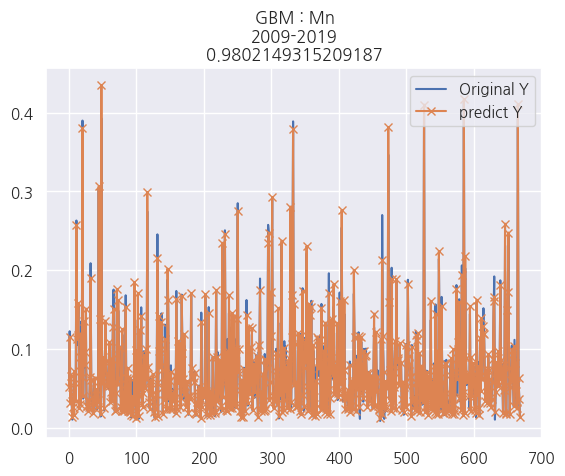

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Mn RF 예측 RMSE :  0.00833774378712067
Mn RF 예측 R2 :  0.9821236165724522
Mn RF 예측 MSE :  6.951797145966935e-05
Mn RF 예측 MAE :  0.004554857863063703


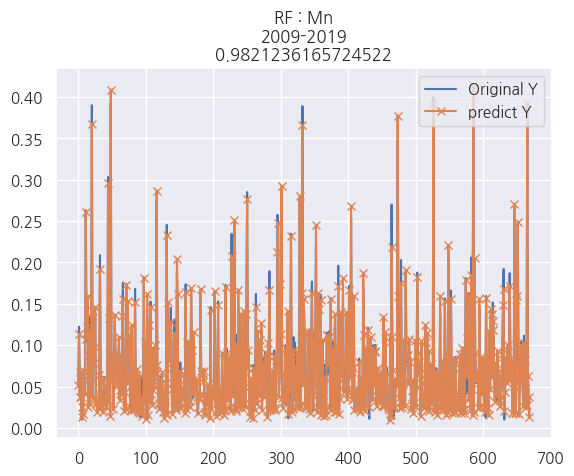

일반
best list :  ['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1', 'mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'mn1real']
best R2 :  0.9821236165724522
best Model : RF


In [33]:
# 첫번쨰 학습 # 각 모델에 맞는 열 생성
best_list = list()
best_r2 = 0
best_md = ""
for md in model_list:
    count = 0
    for df in var_list:
        """
        Modulation 2 : 학습데이터 정제
        """
        # trainX, testX, trainY, testY = train_test_split(
        #     train_data2[df[:-1]],
        #     train_data2[y_var],
        #     test_size=0.2,
        #     random_state=42,
        #     shuffle=True)

        # xy = train_data[df].iloc[(train_data.index >= start_date) & (train_data.index <= end_date)]
        xy = train_data[df]

        trainX, testX, trainY, testY = train_test_split(xy.drop([y_var], axis=1), xy[y_var],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                   random_state=45)


        """
        Modulation 3 : 모델 학습
        """
        # print("Modulation 3 : 모델 학습")

        if md == "GBM":
            model, predict = AL_GradientBoosting(trainX, testX, trainY, testY)
        elif md == "RF":
            model, predict = AL_RandomForest(trainX, testX, trainY, testY)
        elif md == "SVR":
            model, predict = AL_SVR(trainX, testX, trainY, testY)
        elif md == "XGB":
            model, predict = AL_XGBoosting(trainX, testX, trainY, testY)

        yhat = predict
        actual = testY

        # pd.DataFrame(yhat).to_csv("주암댐_lead3_pred.csv", encoding='cp949')
        # actual.to_csv('주암댐_lead3_actual.csv', encoding='cp949')
        # break


        # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
        for pi in performance_list:
            rmse = Performance_index(actual, yhat, pi)
            print(temp_list_name[count] + " " + md + ' 예측 ' + pi + ' : ', rmse)
        r2 = Performance_index(actual, yhat, "R2")
        if r2 > best_r2:
            best_r2 = r2
            best_list = df
            best_md = md

        """
        Modulation 4 : 결과 데이터 저장
        """
        # print("Modulation 4 : 결과 데이터 저장")
        # print("")

        # 복원된 데이터 저장
        # pd_actual_save = pd.DataFrame(actual)
        # pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual", mode='w')
        # pd_predict_save = pd.DataFrame(yhat)
        # pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count], mode='w')

        # 모델 저장
        # joblib(sv_regressor, "svr_model.pkl")
        # with open(md+'_mn.pkl', 'wb') as f:
        #     pickle.dump(model, f)

        # # feature importance 2023-08-11
        # ser = pd.Series(model.feature_importances_, index=xy.drop([y_var], axis=1).columns)
        # feature_importances = ser.sort_values(ascending=False) # 내림차순 정렬
        # plt.figure(figsize=(8,6))
        # plt.title("Feature Importances")
        # sns.barplot(x=feature_importances, y=feature_importances.index)

        # 그래프 저장
        basic_chart(actual, yhat, 'line')
        plt.title(md + " : " + temp_list_name[0] + "\n" + start_date.split('-')[0] + "-" + end_date.split('-')[0] + "\n" + str(Performance_index(actual, yhat, "R2")))
        # plt.savefig(dir_list['graph'][0] + temp_list_name[0] + '.png')
        plt.show()

        # 학습된 모델로 leadtime1
        train_data[md+'_pred_lead1'] = model.predict(train_data[['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5']])

        count += 1

# plt.show()
print("일반")
print("best list : ", best_list)
print("best R2 : ", best_r2)
print("best Model :", best_md)

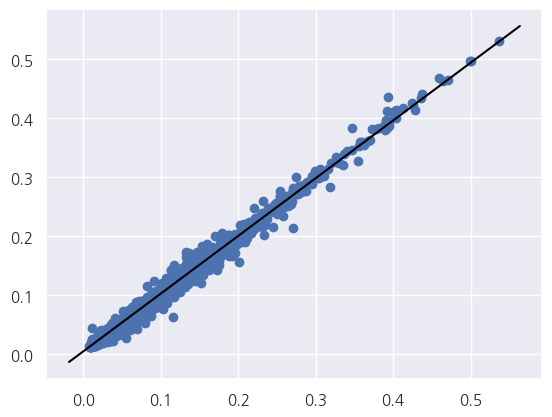

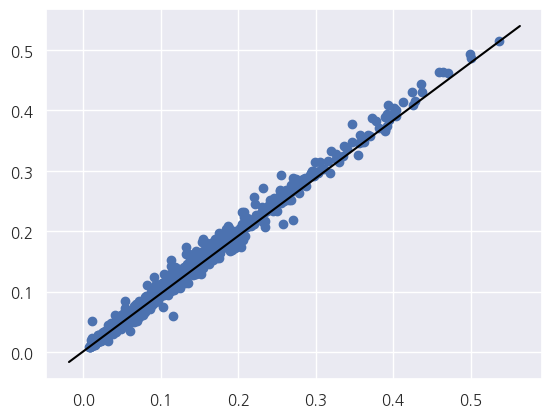

In [34]:
# GBM pred_read1 R2 그래프
plt.scatter(train_data['mn1real'], train_data['GBM_pred_lead1'])
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

# RF pred_read1 R2 그래프
plt.scatter(train_data['mn1real'], train_data['RF_pred_lead1'])
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

In [35]:
# 망간 농도 예측 # mn_lead2 열
model_list = ["GBM", "RF"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF, SVR
performance_list = ["RMSE", "R2", "MSE", "MAE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE

var_list = [['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'mn2real']]
y_var = "mn2real"

target=0  # 0은 당일 mn, 1은 다음 주프레임 mn 예측
seqLength=0

temp_list_name = ["Mn"]
trainSize_rate = 0.8  # 학습 및 예측 셋 구분

Mn GBM 예측 RMSE :  0.012069666450462023
Mn GBM 예측 R2 :  0.9617887268370224
Mn GBM 예측 MSE :  0.00014567684822540852
Mn GBM 예측 MAE :  0.00759251161150642


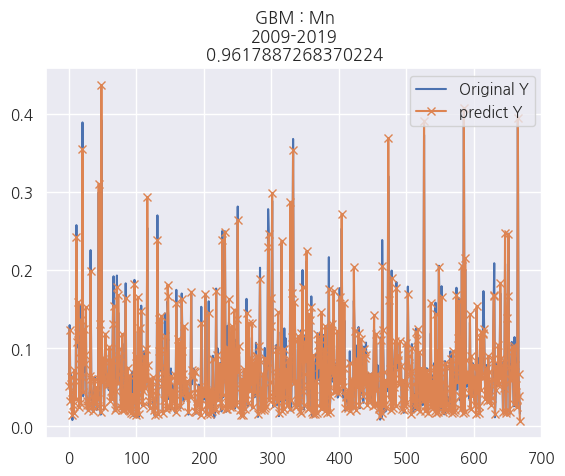

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Mn RF 예측 RMSE :  0.01163307637810112
Mn RF 예측 R2 :  0.9645031242454718
Mn RF 예측 MSE :  0.00013532846601873428
Mn RF 예측 MAE :  0.0065422597036993956


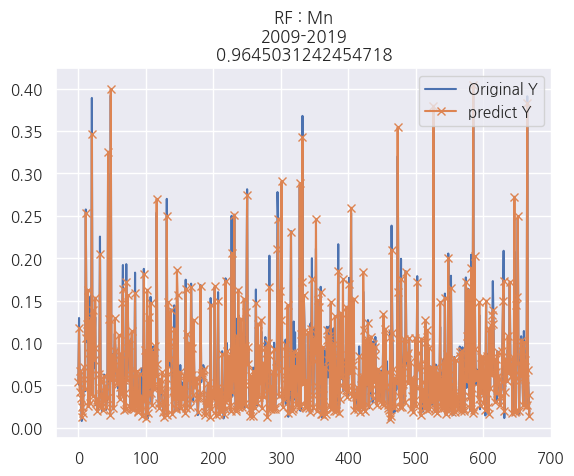

일반
best list :  ['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1', 'mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'mn2real']
best R2 :  0.9645031242454718
best Model : RF


In [36]:
# 첫번쨰 학습 # 각 모델에 맞는 열 생성
best_list = list()
best_r2 = 0
best_md = ""
for md in model_list:
    count = 0
    for df in var_list:
        """
        Modulation 2 : 학습데이터 정제
        """
        # trainX, testX, trainY, testY = train_test_split(
        #     train_data2[df[:-1]],
        #     train_data2[y_var],
        #     test_size=0.2,
        #     random_state=42,
        #     shuffle=True)

        # xy = train_data[df].iloc[(train_data.index >= start_date) & (train_data.index <= end_date)]
        xy = train_data[df]

        trainX, testX, trainY, testY = train_test_split(xy.drop([y_var], axis=1), xy[y_var],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                   random_state=45)


        """
        Modulation 3 : 모델 학습
        """
        # print("Modulation 3 : 모델 학습")

        if md == "GBM":
            model, predict = AL_GradientBoosting(trainX, testX, trainY, testY)
        elif md == "RF":
            model, predict = AL_RandomForest(trainX, testX, trainY, testY)
        elif md == "SVR":
            model, predict = AL_SVR(trainX, testX, trainY, testY)
        elif md == "XGB":
            model, predict = AL_XGBoosting(trainX, testX, trainY, testY)

        yhat = predict
        actual = testY

        # pd.DataFrame(yhat).to_csv("주암댐_lead3_pred.csv", encoding='cp949')
        # actual.to_csv('주암댐_lead3_actual.csv', encoding='cp949')
        # break


        # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
        for pi in performance_list:
            rmse = Performance_index(actual, yhat, pi)
            print(temp_list_name[count] + " " + md + ' 예측 ' + pi + ' : ', rmse)
        r2 = Performance_index(actual, yhat, "R2")
        if r2 > best_r2:
            best_r2 = r2
            best_list = df
            best_md = md

        """
        Modulation 4 : 결과 데이터 저장
        """
        # print("Modulation 4 : 결과 데이터 저장")
        # print("")

        # 복원된 데이터 저장
        # pd_actual_save = pd.DataFrame(actual)
        # pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual", mode='w')
        # pd_predict_save = pd.DataFrame(yhat)
        # pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count], mode='w')

        # 모델 저장
        # joblib(sv_regressor, "svr_model.pkl")
        # with open(md+'_mn.pkl', 'wb') as f:
        #     pickle.dump(model, f)

        # # feature importance 2023-08-11
        # ser = pd.Series(model.feature_importances_, index=xy.drop([y_var], axis=1).columns)
        # feature_importances = ser.sort_values(ascending=False) # 내림차순 정렬
        # plt.figure(figsize=(8,6))
        # plt.title("Feature Importances")
        # sns.barplot(x=feature_importances, y=feature_importances.index)

        # 그래프 저장
        basic_chart(actual, yhat, 'line')
        plt.title(md + " : " + temp_list_name[0] + "\n" + start_date.split('-')[0] + "-" + end_date.split('-')[0] + "\n" + str(Performance_index(actual, yhat, "R2")))
        # plt.savefig(dir_list['graph'][0] + temp_list_name[0] + '.png')
        plt.show()

        # 학습된 모델로 leadtime2
        train_data[md+'_pred_lead2'] = model.predict(train_data[['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5']])

        count += 1

# plt.show()
print("일반")
print("best list : ", best_list)
print("best R2 : ", best_r2)
print("best Model :", best_md)

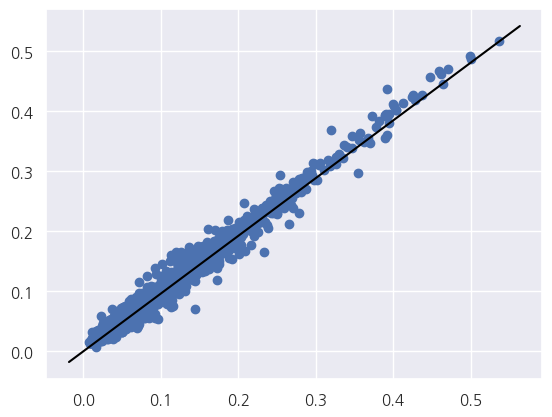

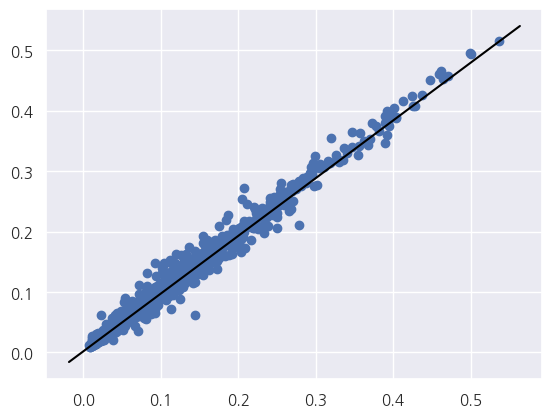

In [37]:
# GBM pred_read2 R2 그래프
plt.scatter(train_data['mn2real'], train_data['GBM_pred_lead2'])
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

# RF pred_read2 R2 그래프
plt.scatter(train_data['mn2real'], train_data['RF_pred_lead2'])
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

In [40]:
# 망간 농도 예측 # mn_lead2 열
model_list = ["GBM", "RF"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF, SVR
performance_list = ["RMSE", "R2", "MSE", "MAE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE

var_list = [['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'mn3real']]
y_var = "mn3real"

target=0  # 0은 당일 mn, 1은 다음 주프레임 mn 예측
seqLength=0

temp_list_name = ["Mn"]
trainSize_rate = 0.8  # 학습 및 예측 셋 구분

Mn GBM 예측 RMSE :  0.015365584181109266
Mn GBM 예측 R2 :  0.9363373491760199
Mn GBM 예측 MSE :  0.0002361011772267553
Mn GBM 예측 MAE :  0.00994982830585388


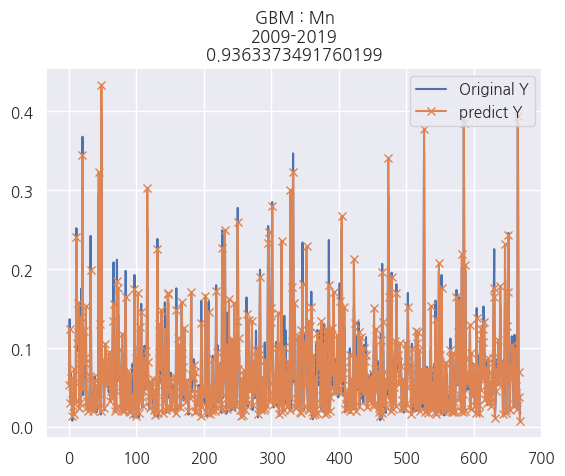

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


Mn RF 예측 RMSE :  0.01431145628908222
Mn RF 예측 R2 :  0.9447726477488094
Mn RF 예측 MSE :  0.00020481778111431105
Mn RF 예측 MAE :  0.008060881719285533


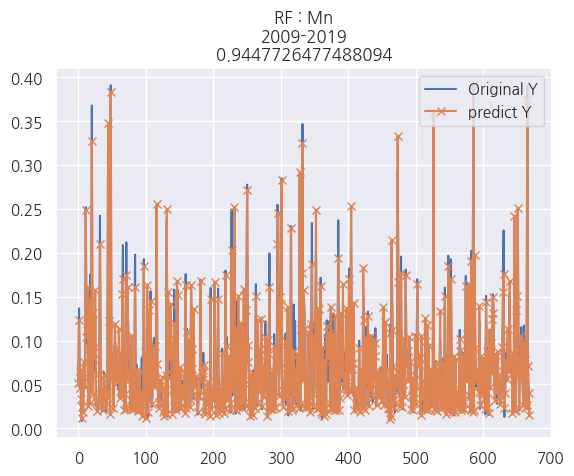

일반
best list :  ['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1', 'mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'mn3real']
best R2 :  0.9447726477488094
best Model : RF


In [41]:
# 첫번쨰 학습 # 각 모델에 맞는 열 생성
best_list = list()
best_r2 = 0
best_md = ""
for md in model_list:
    count = 0
    for df in var_list:
        """
        Modulation 2 : 학습데이터 정제
        """
        # trainX, testX, trainY, testY = train_test_split(
        #     train_data2[df[:-1]],
        #     train_data2[y_var],
        #     test_size=0.2,
        #     random_state=42,
        #     shuffle=True)

        # xy = train_data[df].iloc[(train_data.index >= start_date) & (train_data.index <= end_date)]
        xy = train_data[df]

        trainX, testX, trainY, testY = train_test_split(xy.drop([y_var], axis=1), xy[y_var],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                   random_state=45)


        """
        Modulation 3 : 모델 학습
        """
        # print("Modulation 3 : 모델 학습")

        if md == "GBM":
            model, predict = AL_GradientBoosting(trainX, testX, trainY, testY)
        elif md == "RF":
            model, predict = AL_RandomForest(trainX, testX, trainY, testY)
        elif md == "SVR":
            model, predict = AL_SVR(trainX, testX, trainY, testY)
        elif md == "XGB":
            model, predict = AL_XGBoosting(trainX, testX, trainY, testY)

        yhat = predict
        actual = testY

        # pd.DataFrame(yhat).to_csv("주암댐_lead3_pred.csv", encoding='cp949')
        # actual.to_csv('주암댐_lead3_actual.csv', encoding='cp949')
        # break


        # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
        for pi in performance_list:
            rmse = Performance_index(actual, yhat, pi)
            print(temp_list_name[count] + " " + md + ' 예측 ' + pi + ' : ', rmse)
        r2 = Performance_index(actual, yhat, "R2")
        if r2 > best_r2:
            best_r2 = r2
            best_list = df
            best_md = md

        """
        Modulation 4 : 결과 데이터 저장
        """
        # print("Modulation 4 : 결과 데이터 저장")
        # print("")

        # 복원된 데이터 저장
        # pd_actual_save = pd.DataFrame(actual)
        # pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual", mode='w')
        # pd_predict_save = pd.DataFrame(yhat)
        # pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count], mode='w')

        # 모델 저장
        # joblib(sv_regressor, "svr_model.pkl")
        # with open(md+'_mn.pkl', 'wb') as f:
        #     pickle.dump(model, f)

        # # feature importance 2023-08-11
        # ser = pd.Series(model.feature_importances_, index=xy.drop([y_var], axis=1).columns)
        # feature_importances = ser.sort_values(ascending=False) # 내림차순 정렬
        # plt.figure(figsize=(8,6))
        # plt.title("Feature Importances")
        # sns.barplot(x=feature_importances, y=feature_importances.index)

        # 그래프 저장
        basic_chart(actual, yhat, 'line')
        plt.title(md + " : " + temp_list_name[0] + "\n" + start_date.split('-')[0] + "-" + end_date.split('-')[0] + "\n" + str(Performance_index(actual, yhat, "R2")))
        # plt.savefig(dir_list['graph'][0] + temp_list_name[0] + '.png')
        plt.show()

        # 학습된 모델로 leadtime3
        train_data[md+'_pred_lead3'] = model.predict(train_data[['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5']])

        count += 1

# plt.show()
print("일반")
print("best list : ", best_list)
print("best R2 : ", best_r2)
print("best Model :", best_md)

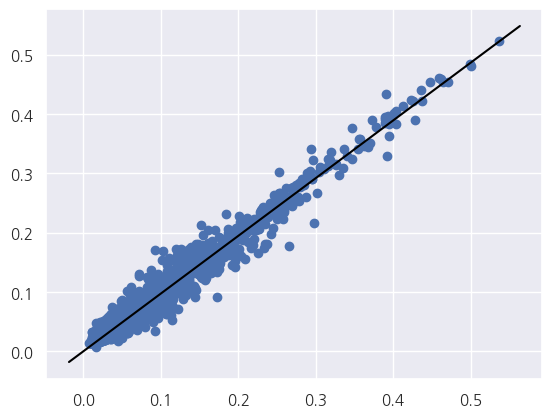

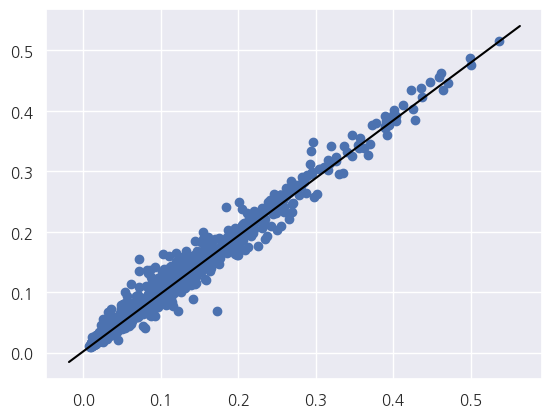

In [43]:
# GBM pred_read3 R2 그래프
plt.scatter(train_data['mn3real'], train_data['GBM_pred_lead3'])
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

# RF pred_read3 R2 그래프
plt.scatter(train_data['mn3real'], train_data['RF_pred_lead3'])
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

In [44]:
train_data

,ELCCND,DO,PH,WTRTMP,댐수위,저수량,강우량,TMn_HS,pea,mn_linear,...,mn1real,mn2real,mn3real,mn4real,GBM_pred_lead1,RF_pred_lead1,GBM_pred_lead2,RF_pred_lead2,GBM_pred_lead3,RF_pred_lead3
2009-12-21,0.443560,0.104519,0.651474,0.088770,0.460260,0.343840,0.001452,NaN,0.009092,0.172000,...,0.174000,0.193000,0.212000,0.231000,0.175589,0.173053,0.178019,0.172324,0.184952,0.174143
2009-12-24,0.000018,0.108223,0.645318,0.086160,0.455065,0.339065,0.000000,NaN,0.003851,0.212000,...,0.231000,0.250000,0.269000,0.288000,0.214356,0.216574,0.229212,0.223721,0.244438,0.232381
2009-12-29,0.000000,0.108674,0.646730,0.079118,0.446234,0.331016,0.000000,0.565217,0.002601,0.307000,...,0.303333,0.299667,0.296000,0.292333,0.306271,0.296082,0.310684,0.325802,0.323198,0.347893
2009-12-30,0.000000,0.113472,0.646404,0.078261,0.444156,0.329133,0.000000,NaN,0.003001,0.303333,...,0.299667,0.296000,0.292333,0.288667,0.310429,0.313749,0.312838,0.313936,0.303670,0.312317
2009-12-31,0.000000,0.118853,0.646532,0.076654,0.442597,0.327721,0.003387,NaN,0.002359,0.299667,...,0.296000,0.292333,0.288667,0.285000,0.295785,0.300431,0.298438,0.297575,0.290589,0.293903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.392029,0.118225,0.638743,0.108422,0.801039,0.704278,0.000000,0.081285,0.006204,0.051000,...,0.050000,0.049000,0.048000,0.047000,0.052440,0.050183,0.053167,0.049466,0.057042,0.048828
2019-12-24,0.392200,0.118531,0.638575,0.107742,0.799481,0.702225,0.000000,NaN,0.005604,0.050000,...,0.049000,0.048000,0.047000,0.046000,0.052812,0.050492,0.053167,0.049632,0.057042,0.048379
2019-12-25,0.392645,0.118218,0.638032,0.106714,0.797403,0.699494,0.000000,NaN,0.004834,0.049000,...,0.048000,0.047000,0.046000,0.045000,0.052643,0.049444,0.053167,0.048207,0.057042,0.046823
2019-12-26,0.392508,0.118935,0.638155,0.105815,0.795325,0.696773,0.004809,NaN,0.004221,0.048000,...,0.047000,0.046000,0.045000,0.044000,0.051292,0.047354,0.053132,0.046387,0.057341,0.045432


In [45]:
# 망간 농도 예측 # 실제 망간 농도 예측
model_list = ["GBM"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF, SVR
performance_list = ["RMSE", "R2", "MSE", "MAE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE

var_list = [['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'GBM_pred_lead1', 'GBM_pred_lead2', 'GBM_pred_lead3', 'mn4real']]
y_var = "mn4real"

target=0  # 0은 당일 mn, 1은 다음 주프레임 mn 예측
seqLength=0

temp_list_name = ["Mn"]
trainSize_rate = 0.8  # 학습 및 예측 셋 구분

Mn GBM 예측 RMSE :  0.017527984380799982
Mn GBM 예측 R2 :  0.9164006642784456
Mn GBM 예측 MSE :  0.0003072302364535681
Mn GBM 예측 MAE :  0.011161376428038158


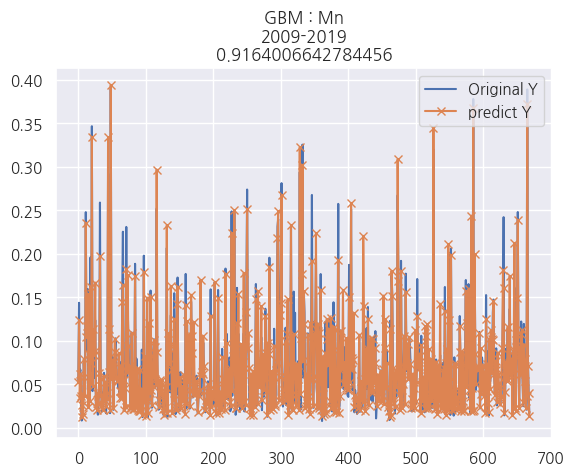

일반
best list :  ['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1', 'mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'GBM_pred_lead1', 'GBM_pred_lead2', 'GBM_pred_lead3', 'mn4real']
best R2 :  0.9164006642784456
best Model : GBM


In [46]:
# 두번쨰 학습 GBM
best_list = list()
best_r2 = 0
best_md = ""
for md in model_list:
    count = 0
    for df in var_list:
        """
        Modulation 2 : 학습데이터 정제
        """
        # trainX, testX, trainY, testY = train_test_split(
        #     train_data2[df[:-1]],
        #     train_data2[y_var],
        #     test_size=0.2,
        #     random_state=42,
        #     shuffle=True)

        # xy = train_data[df].iloc[(train_data.index >= start_date) & (train_data.index <= end_date)]
        xy = train_data[df]

        trainX, testX, trainY, testY = train_test_split(xy.drop([y_var], axis=1), xy[y_var],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                   random_state=45)


        """
        Modulation 3 : 모델 학습
        """
        # print("Modulation 3 : 모델 학습")

        if md == "GBM":
            model, predict = AL_GradientBoosting(trainX, testX, trainY, testY)
        elif md == "RF":
            model, predict = AL_RandomForest(trainX, testX, trainY, testY)
        elif md == "SVR":
            model, predict = AL_SVR(trainX, testX, trainY, testY)
        elif md == "XGB":
            model, predict = AL_XGBoosting(trainX, testX, trainY, testY)

        yhat = predict
        actual = testY

        # pd.DataFrame(yhat).to_csv("주암댐_lead3_pred.csv", encoding='cp949')
        # actual.to_csv('주암댐_lead3_actual.csv', encoding='cp949')
        # break


        # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
        for pi in performance_list:
            rmse = Performance_index(actual, yhat, pi)
            print(temp_list_name[count] + " " + md + ' 예측 ' + pi + ' : ', rmse)
        r2 = Performance_index(actual, yhat, "R2")
        if r2 > best_r2:
            best_r2 = r2
            best_list = df
            best_md = md

        """
        Modulation 4 : 결과 데이터 저장
        """
        # print("Modulation 4 : 결과 데이터 저장")
        # print("")

        # 복원된 데이터 저장
        # pd_actual_save = pd.DataFrame(actual)
        # pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual", mode='w')
        # pd_predict_save = pd.DataFrame(yhat)
        # pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count], mode='w')

        # 모델 저장
        # joblib(sv_regressor, "svr_model.pkl")
        # with open(md+'_mn.pkl', 'wb') as f:
        #     pickle.dump(model, f)

        # # feature importance 2023-08-11
        # ser = pd.Series(model.feature_importances_, index=xy.drop([y_var], axis=1).columns)
        # feature_importances = ser.sort_values(ascending=False) # 내림차순 정렬
        # plt.figure(figsize=(8,6))
        # plt.title("Feature Importances")
        # sns.barplot(x=feature_importances, y=feature_importances.index)

        # 그래프 저장
        basic_chart(actual, yhat, 'line')
        plt.title(md + " : " + temp_list_name[0] + "\n" + start_date.split('-')[0] + "-" + end_date.split('-')[0] + "\n" + str(Performance_index(actual, yhat, "R2")))
        # plt.savefig(dir_list['graph'][0] + temp_list_name[0] + '.png')
        plt.show()

        count += 1

# plt.show()
print("일반")
print("best list : ", best_list)
print("best R2 : ", best_r2)
print("best Model :", best_md)

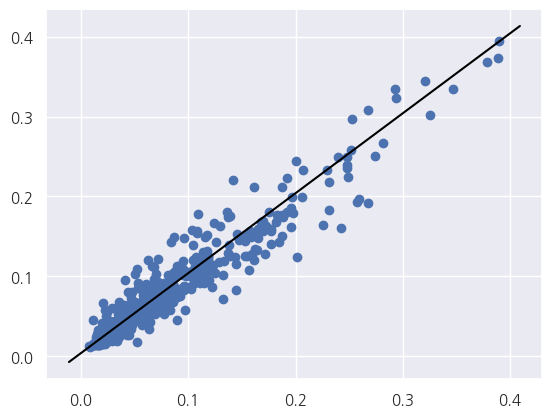

In [47]:
# GBM pred_read1,2,3 R2 그래프
plt.scatter(actual, yhat)
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

In [48]:
# 망간 농도 예측
model_list = ["RF"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF, SVR
performance_list = ["RMSE", "R2", "MSE", "MAE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE

var_list = [['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'RF_pred_lead1', 'RF_pred_lead2', 'RF_pred_lead3', 'mn4real']]
y_var = "mn4real"

target=0  # 0은 당일 mn, 1은 다음 주프레임 mn 예측
seqLength=0

temp_list_name = ["Mn"]
trainSize_rate = 0.8  # 학습 및 예측 셋 구분

Mn RF 예측 RMSE :  0.017048013867950972
Mn RF 예측 R2 :  0.920916396243985
Mn RF 예측 MSE :  0.00029063477684184867
Mn RF 예측 MAE :  0.00925558627056388


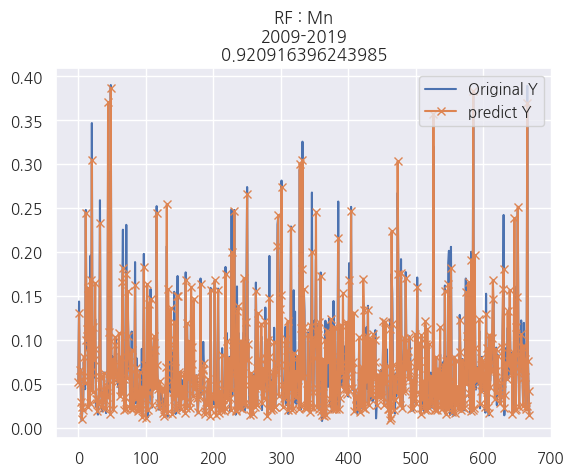

일반
best list :  ['강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1', 'mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'RF_pred_lead1', 'RF_pred_lead2', 'RF_pred_lead3', 'mn4real']
best R2 :  0.920916396243985
best Model : RF


In [49]:
# 두번쨰 학습
best_list = list()
best_r2 = 0
best_md = ""
for md in model_list:
    count = 0
    for df in var_list:
        """
        Modulation 2 : 학습데이터 정제
        """
        # trainX, testX, trainY, testY = train_test_split(
        #     train_data2[df[:-1]],
        #     train_data2[y_var],
        #     test_size=0.2,
        #     random_state=42,
        #     shuffle=True)

        # xy = train_data[df].iloc[(train_data.index >= start_date) & (train_data.index <= end_date)]
        xy = train_data[df]

        trainX, testX, trainY, testY = train_test_split(xy.drop([y_var], axis=1), xy[y_var],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                   random_state=45)


        """
        Modulation 3 : 모델 학습
        """
        # print("Modulation 3 : 모델 학습")

        if md == "GBM":
            model, predict = AL_GradientBoosting(trainX, testX, trainY, testY)
        elif md == "RF":
            model, predict = AL_RandomForest(trainX, testX, trainY, testY)
        elif md == "SVR":
            model, predict = AL_SVR(trainX, testX, trainY, testY)
        elif md == "XGB":
            model, predict = AL_XGBoosting(trainX, testX, trainY, testY)

        yhat = predict
        actual = testY

        # pd.DataFrame(yhat).to_csv("주암댐_lead3_pred.csv", encoding='cp949')
        # actual.to_csv('주암댐_lead3_actual.csv', encoding='cp949')
        # break


        # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
        for pi in performance_list:
            rmse = Performance_index(actual, yhat, pi)
            print(temp_list_name[count] + " " + md + ' 예측 ' + pi + ' : ', rmse)
        r2 = Performance_index(actual, yhat, "R2")
        if r2 > best_r2:
            best_r2 = r2
            best_list = df
            best_md = md

        """
        Modulation 4 : 결과 데이터 저장
        """
        # print("Modulation 4 : 결과 데이터 저장")
        # print("")

        # 복원된 데이터 저장
        # pd_actual_save = pd.DataFrame(actual)
        # pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual", mode='w')
        # pd_predict_save = pd.DataFrame(yhat)
        # pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count], mode='w')

        # 모델 저장
        # joblib(sv_regressor, "svr_model.pkl")
        # with open(md+'_mn.pkl', 'wb') as f:
        #     pickle.dump(model, f)

        # # feature importance 2023-08-11
        # ser = pd.Series(model.feature_importances_, index=xy.drop([y_var], axis=1).columns)
        # feature_importances = ser.sort_values(ascending=False) # 내림차순 정렬
        # plt.figure(figsize=(8,6))
        # plt.title("Feature Importances")
        # sns.barplot(x=feature_importances, y=feature_importances.index)

        # 그래프 저장
        basic_chart(actual, yhat, 'line')
        plt.title(md + " : " + temp_list_name[0] + "\n" + start_date.split('-')[0] + "-" + end_date.split('-')[0] + "\n" + str(Performance_index(actual, yhat, "R2")))
        # plt.savefig(dir_list['graph'][0] + temp_list_name[0] + '.png')
        plt.show()

        count += 1

# plt.show()
print("일반")
print("best list : ", best_list)
print("best R2 : ", best_r2)
print("best Model :", best_md)

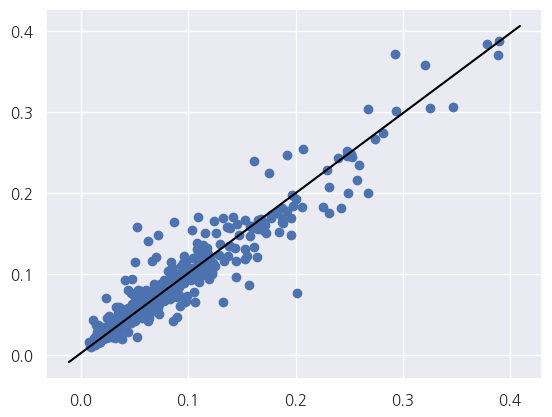

In [50]:
# RF pred_read1,2,3 R2 그래프
plt.scatter(actual, yhat)
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

In [51]:
# month 데이터 추가
train_data['month'] = train_data.index.month

In [52]:
# 망간 농도 예측 + month 추가
model_list = ["GBM"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF, SVR
performance_list = ["RMSE", "R2", "MSE", "MAE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE

var_list = [['month', '강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO','mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'GBM_pred_lead1', 'GBM_pred_lead2', 'GBM_pred_lead3', 'mn4real']]

y_var = "mn4real"

target=2   # 0은 당일 mn, 1은 다음 주프레임 mn 예측
seqLength=0

temp_list_name = ["Mn"]
trainSize_rate = 0.8  # 학습 및 예측 셋 구분

동절기 GBM 예측 RMSE :  0.011982245671148098
하절기 GBM 예측 RMSE :  0.014319995940373793
동절기 GBM 예측 R2 :  0.9714258265559101
하절기 GBM 예측 R2 :  0.9282652695049937
동절기 GBM 예측 MSE :  0.0001435742113237473
하절기 GBM 예측 MSE :  0.0002050622837323219
동절기 GBM 예측 MAE :  0.00770575315763504
하절기 GBM 예측 MAE :  0.00887111509572274


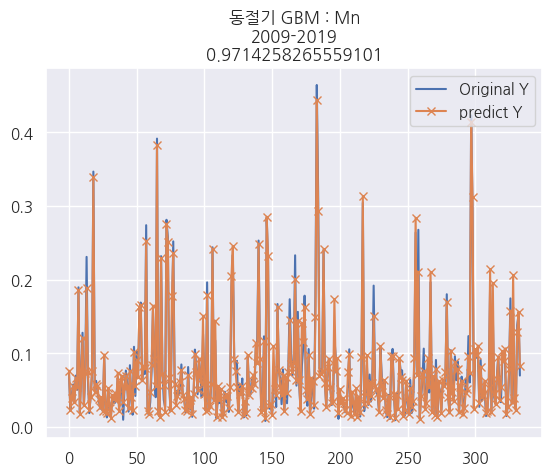

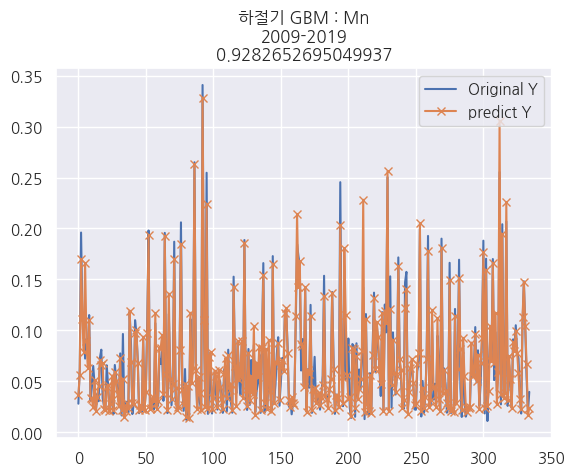

동절기
best list :  ['month', '강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1', 'mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'GBM_pred_lead1', 'GBM_pred_lead2', 'GBM_pred_lead3', 'mn4real']
best R2 :  0.9714258265559101
best Model : GBM
하절기
best list :  ['month', '강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1', 'mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'GBM_pred_lead1', 'GBM_pred_lead2', 'GBM_pred_lead3', 'mn4real']
best R2 :  0.9282652695049937
best Model : GBM


In [53]:
# 동절기 하절기 일반
best_list1 = list()
best_r2_1 = 0
best_md1 = ""

best_list2 = list()
best_r2_2 = 0
best_md2 = ""
for md in model_list:
    count = 0
    for df in var_list:
        """
        Modulation 2 : 학습데이터 정제
        """
        # trainX, testX, trainY, testY = train_test_split(
        #     train_data2[df[:-1]],
        #     train_data2[y_var],
        #     test_size=0.2,
        #     random_state=42,
        #     shuffle=True)

        # xy = train_data[df].iloc[(train_data.index >= start_date) & (train_data.index <= end_date)]
        xy = train_data[df]

        # 동절기
        xy1 = xy[((xy['month'] >= 10) & (xy['month'] <= 12)) |
                 ((xy['month'] >= 1) & (xy['month'] < 4))]

        # 하절기
        xy2 = xy[(xy['month'] >= 4) & (xy['month'] < 10)]

        # month 제거
        xy1 = xy1.drop("month", axis=1)
        xy2 = xy2.drop("month", axis=1)

        trainX1, testX1, trainY1, testY1 = train_test_split(xy1.drop([y_var], axis=1), xy1[y_var],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                   random_state=45)
        trainX2, testX2, trainY2, testY2 = train_test_split(xy2.drop([y_var], axis=1), xy2[y_var],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                   random_state=45)

        # print(trainX)
        # break

#         print("@ :",trainY)
#         break

        """
        Modulation 3 : 모델 학습
        """
        # print("Modulation 3 : 모델 학습")
        if md == "GBM":
            model1, predict1 = AL_GradientBoosting(trainX1, testX1, trainY1, testY1)
            model2, predict2 = AL_GradientBoosting(trainX2, testX2, trainY2, testY2)
        elif md == "RF":
            model1, predict1 = AL_RandomForest(trainX1, testX1, trainY1, testY1)
            model2, predict2 = AL_RandomForest(trainX2, testX2, trainY2, testY2)
        elif md == "SVR":
            model1, predict1 = AL_SVR(trainX1, testX1, trainY1, testY1)
            model2, predict2 = AL_SVR(trainX2, testX2, trainY2, testY2)
        elif md == "XGB":
            model1, predict1 = AL_XGBoosting(trainX1, testX1, trainY1, testY1)
            model2, predict2 = AL_XGBoosting(trainX2, testX2, trainY2, testY2)

        yhat1 = predict1
        actual1 = testY1
        yhat2 = predict2
        actual2 = testY2

        # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
        for pi in performance_list:
            rmse1 = Performance_index(actual1, yhat1, pi)
            rmse2 = Performance_index(actual2, yhat2, pi)
            print("동절기 " + md + ' 예측 ' + pi + ' : ', rmse1)
            print("하절기 " + md + ' 예측 ' + pi + ' : ', rmse2)
        r2_1 = Performance_index(actual1, yhat1, "R2")
        r2_2 = Performance_index(actual2, yhat2, "R2")
        if r2_1 > best_r2_1:
            best_r2_1 = r2_1
            best_list1 = df
            best_md1 = md

        if r2_2 > best_r2_2:
            best_r2_2 = r2_2
            best_list2 = df
            best_md2 = md

        """
        Modulation 4 : 결과 데이터 저장
        """
        # print("Modulation 4 : 결과 데이터 저장")
        # print("")

        # 복원된 데이터 저장
        # pd_actual_save = pd.DataFrame(actual)
        # pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual", mode='w')
        # pd_predict_save = pd.DataFrame(yhat)
        # pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count], mode='w')

        # 모델 저장
        # joblib(sv_regressor, "svr_model.pkl")
        with open(md+'_mn_동절기.pkl', 'wb') as f:
            pickle.dump(model1, f)

        with open(md+'_mn_하절기.pkl', 'wb') as f:
            pickle.dump(model2, f)

        # # feature importance 2023-08-11
#         ser = pd.Series(model1.feature_importances_, index=xy.drop([y_var, 'month'], axis=1).columns)
#         feature_importances = ser.sort_values(ascending=False) # 내림차순 정렬
#         plt.figure(figsize=(8,6))
#         plt.title("동절기 Feature Importances")
#         sns.barplot(x=feature_importances, y=feature_importances.index)

#         ser = pd.Series(model2.feature_importances_, index=xy.drop([y_var, 'month'], axis=1).columns)
#         feature_importances = ser.sort_values(ascending=False) # 내림차순 정렬
#         plt.figure(figsize=(8,6))
#         plt.title("하절기 Feature Importances")
#         sns.barplot(x=feature_importances, y=feature_importances.index)

        # 그래프 저장
        basic_chart(actual1, yhat1, 'line')
        plt.title("동절기 " + md + " : " + temp_list_name[0] + "\n" + start_date.split('-')[0] + "-" + end_date.split('-')[0] + "\n" + str(Performance_index(actual1, yhat1, "R2")))
        # plt.savefig(dir_list['graph'][0] + temp_list_name[0] + '.png')
        basic_chart(actual2, yhat2, 'line')
        plt.title("하절기 " + md + " : " + temp_list_name[0] + "\n" + start_date.split('-')[0] + "-" + end_date.split('-')[0] + "\n" + str(Performance_index(actual2, yhat2, "R2")))
        # plt.savefig(dir_list['graph'][0] + temp_list_name[0] + '.png')
        plt.show()

        count += 1

# plt.show()
print("동절기")
print("best list : ", best_list1)
print("best R2 : ", best_r2_1)
print("best Model :", best_md1)

print("하절기")
print("best list : ", best_list2)
print("best R2 : ", best_r2_2)
print("best Model :", best_md2)

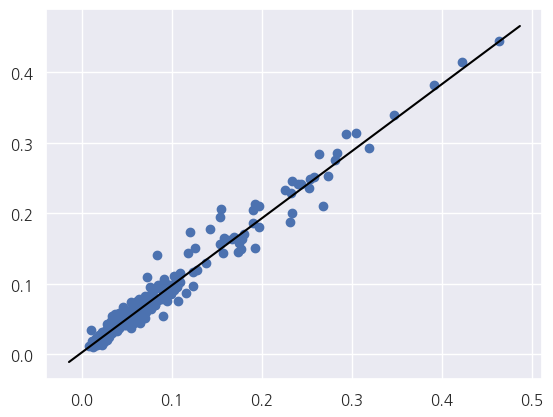

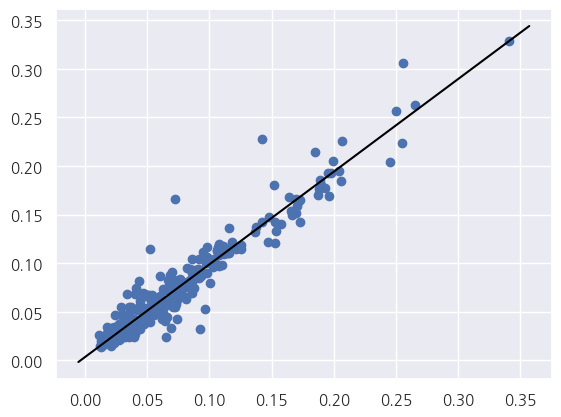

In [54]:
# GBM pred_lead1,2,3 동절기 R2 그래프
plt.scatter(actual1, yhat1)
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

# GBM pred_lead1,2,3 하절기 R2 그래프
plt.scatter(actual2, yhat2)
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

In [55]:
# 망간 농도 예측 + month 추가
model_list = ["RF"]   # 분석 모델 리스트 설정 : LSTM, GBM, RF, SVR
performance_list = ["RMSE", "R2", "MSE", "MAE"]    # 분석 성능평가 리스트 설정 : RMSE, R2, MSE, MAE

var_list = [['month', '강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO','mn_reg1','mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'RF_pred_lead1', 'RF_pred_lead2', 'RF_pred_lead3', 'mn4real']]

y_var = "mn4real"

target=2   # 0은 당일 mn, 1은 다음 주프레임 mn 예측
seqLength=0

temp_list_name = ["Mn"]
trainSize_rate = 0.8  # 학습 및 예측 셋 구분

동절기 RF 예측 RMSE :  0.012694203487756404
하절기 RF 예측 RMSE :  0.012460322332477961
동절기 RF 예측 R2 :  0.9679293214530013
하절기 RF 예측 R2 :  0.9456871946381363
동절기 RF 예측 MSE :  0.00016114280218856684
하절기 RF 예측 MSE :  0.00015525963262924902
동절기 RF 예측 MAE :  0.0054355083959786235
하절기 RF 예측 MAE :  0.006008170300876566


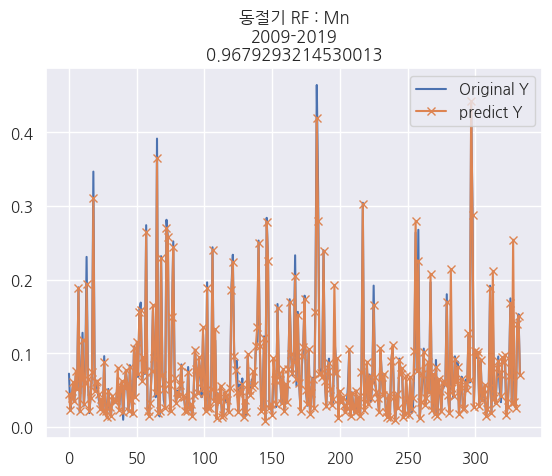

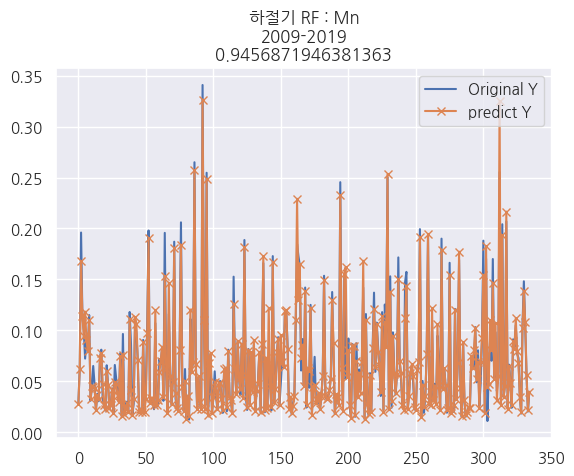

동절기
best list :  ['month', '강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1', 'mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'RF_pred_lead1', 'RF_pred_lead2', 'RF_pred_lead3', 'mn4real']
best R2 :  0.9679293214530013
best Model : RF
하절기
best list :  ['month', '강우량', '댐수위', '저수량', 'PH', 'WTRTMP', 'ELCCND', 'DO', 'mn_reg1', 'mn_reg2', 'mn_reg3', 'mn_reg4', 'mn_reg5', 'RF_pred_lead1', 'RF_pred_lead2', 'RF_pred_lead3', 'mn4real']
best R2 :  0.9456871946381363
best Model : RF


In [56]:
# 동절기 하절기 일반
best_list1 = list()
best_r2_1 = 0
best_md1 = ""

best_list2 = list()
best_r2_2 = 0
best_md2 = ""
for md in model_list:
    count = 0
    for df in var_list:
        """
        Modulation 2 : 학습데이터 정제
        """
        # trainX, testX, trainY, testY = train_test_split(
        #     train_data2[df[:-1]],
        #     train_data2[y_var],
        #     test_size=0.2,
        #     random_state=42,
        #     shuffle=True)

        # xy = train_data[df].iloc[(train_data.index >= start_date) & (train_data.index <= end_date)]
        xy = train_data[df]

        # 동절기
        xy1 = xy[((xy['month'] >= 10) & (xy['month'] <= 12)) |
                 ((xy['month'] >= 1) & (xy['month'] < 4))]

        # 하절기
        xy2 = xy[(xy['month'] >= 4) & (xy['month'] < 10)]

        # month 제거
        xy1 = xy1.drop("month", axis=1)
        xy2 = xy2.drop("month", axis=1)

        trainX1, testX1, trainY1, testY1 = train_test_split(xy1.drop([y_var], axis=1), xy1[y_var],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                   random_state=45)
        trainX2, testX2, trainY2, testY2 = train_test_split(xy2.drop([y_var], axis=1), xy2[y_var],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                   random_state=45)

        # print(trainX)
        # break

#         print("@ :",trainY)
#         break

        """
        Modulation 3 : 모델 학습
        """
        # print("Modulation 3 : 모델 학습")
        if md == "GBM":
            model1, predict1 = AL_GradientBoosting(trainX1, testX1, trainY1, testY1)
            model2, predict2 = AL_GradientBoosting(trainX2, testX2, trainY2, testY2)
        elif md == "RF":
            model1, predict1 = AL_RandomForest(trainX1, testX1, trainY1, testY1)
            model2, predict2 = AL_RandomForest(trainX2, testX2, trainY2, testY2)
        elif md == "SVR":
            model1, predict1 = AL_SVR(trainX1, testX1, trainY1, testY1)
            model2, predict2 = AL_SVR(trainX2, testX2, trainY2, testY2)
        elif md == "XGB":
            model1, predict1 = AL_XGBoosting(trainX1, testX1, trainY1, testY1)
            model2, predict2 = AL_XGBoosting(trainX2, testX2, trainY2, testY2)

        yhat1 = predict1
        actual1 = testY1
        yhat2 = predict2
        actual2 = testY2

        # 성과지표 표출 부분 : 적용 항목은 confing > performance_list[] 참조
        for pi in performance_list:
            rmse1 = Performance_index(actual1, yhat1, pi)
            rmse2 = Performance_index(actual2, yhat2, pi)
            print("동절기 " + md + ' 예측 ' + pi + ' : ', rmse1)
            print("하절기 " + md + ' 예측 ' + pi + ' : ', rmse2)
        r2_1 = Performance_index(actual1, yhat1, "R2")
        r2_2 = Performance_index(actual2, yhat2, "R2")
        if r2_1 > best_r2_1:
            best_r2_1 = r2_1
            best_list1 = df
            best_md1 = md

        if r2_2 > best_r2_2:
            best_r2_2 = r2_2
            best_list2 = df
            best_md2 = md

        """
        Modulation 4 : 결과 데이터 저장
        """
        # print("Modulation 4 : 결과 데이터 저장")
        # print("")

        # 복원된 데이터 저장
        # pd_actual_save = pd.DataFrame(actual)
        # pd_actual_save.to_csv(dir_list['data'][0] + temp_list_name[count] + "_actual", mode='w')
        # pd_predict_save = pd.DataFrame(yhat)
        # pd_predict_save.to_csv(dir_list['data'][0] + temp_list_name[count], mode='w')

        # 모델 저장
        # joblib(sv_regressor, "svr_model.pkl")
        with open(md+'_mn_동절기.pkl', 'wb') as f:
            pickle.dump(model1, f)

        with open(md+'_mn_하절기.pkl', 'wb') as f:
            pickle.dump(model2, f)

        # # feature importance 2023-08-11
#         ser = pd.Series(model1.feature_importances_, index=xy.drop([y_var, 'month'], axis=1).columns)
#         feature_importances = ser.sort_values(ascending=False) # 내림차순 정렬
#         plt.figure(figsize=(8,6))
#         plt.title("동절기 Feature Importances")
#         sns.barplot(x=feature_importances, y=feature_importances.index)

#         ser = pd.Series(model2.feature_importances_, index=xy.drop([y_var, 'month'], axis=1).columns)
#         feature_importances = ser.sort_values(ascending=False) # 내림차순 정렬
#         plt.figure(figsize=(8,6))
#         plt.title("하절기 Feature Importances")
#         sns.barplot(x=feature_importances, y=feature_importances.index)

        # 그래프 저장
        basic_chart(actual1, yhat1, 'line')
        plt.title("동절기 " + md + " : " + temp_list_name[0] + "\n" + start_date.split('-')[0] + "-" + end_date.split('-')[0] + "\n" + str(Performance_index(actual1, yhat1, "R2")))
        # plt.savefig(dir_list['graph'][0] + temp_list_name[0] + '.png')
        basic_chart(actual2, yhat2, 'line')
        plt.title("하절기 " + md + " : " + temp_list_name[0] + "\n" + start_date.split('-')[0] + "-" + end_date.split('-')[0] + "\n" + str(Performance_index(actual2, yhat2, "R2")))
        # plt.savefig(dir_list['graph'][0] + temp_list_name[0] + '.png')
        plt.show()

        count += 1

# plt.show()
print("동절기")
print("best list : ", best_list1)
print("best R2 : ", best_r2_1)
print("best Model :", best_md1)

print("하절기")
print("best list : ", best_list2)
print("best R2 : ", best_r2_2)
print("best Model :", best_md2)

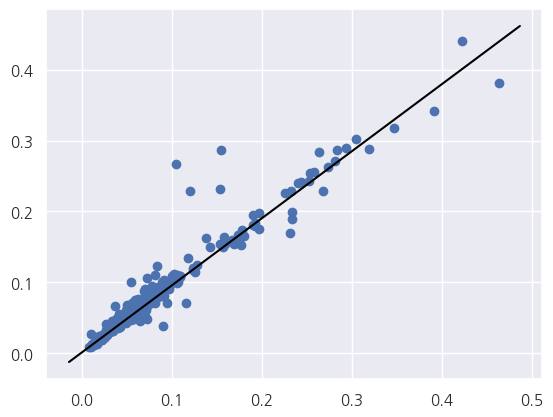

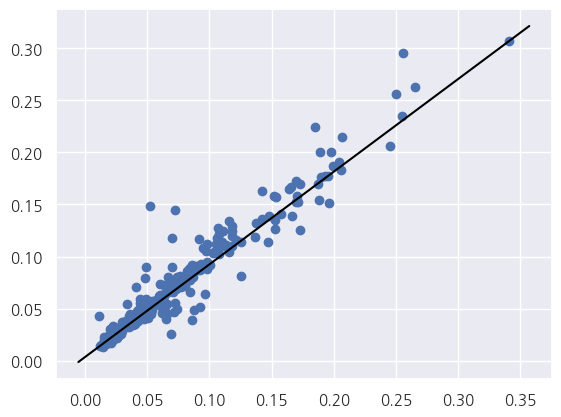

In [ ]:
# RF pred_lead1,2,3 동절기 R2 그래프
plt.scatter(actual1, yhat1)
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()

# RF pred_lead1,2,3 하절기 R2 그래프
plt.scatter(actual2, yhat2)
plt.plot(plt.xlim(), plt.ylim(), color='black')
plt.show()